<a href="https://colab.research.google.com/github/mnarasim/mle9_capstone/blob/develop/Spotify_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import numpy as np
import sklearn
import torch
import torchaudio
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import skimage.io
from PIL import Image
from google.colab import drive 
drive.mount('/content/drive')
import os
import IPython.display as ipd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#Load the files from Google drive
DRIVE_FOLDER = '/content/drive/My Drive/data/false/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
false_dict = {'name':[]}
for file in entries:

    false_dict['name'].append(file)
DRIVE_FOLDER = '/content/drive/My Drive/data/true/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
true_dict = {'name':[]}
for file in entries:

    true_dict['name'].append(file)

In [22]:
#Save the names of the audio files as a dataframe
df1 = pd.DataFrame(false_dict)
df1['label'] = 0
df1['path'] = '/content/drive/My Drive/data/false/'

df2 = pd.DataFrame(true_dict)
df2['label'] = 1
df2['path'] = '/content/drive/My Drive/data/true/'
# combine both dataframes
df = pd.concat([df1,df2])
df = df.sample(frac=1, random_state=56).reset_index(drop=True)

print('The length of the dataset is: ', f'{df.shape[0]:,}')

labels = df['label'].unique()
df.head(10)

The length of the dataset is:  1,435


name  label                                 path
0     Mani_false475.wav      0  /content/drive/My Drive/data/false/
1           Mani356.wav      1   /content/drive/My Drive/data/true/
2     Mani_false427.wav      0  /content/drive/My Drive/data/false/
3  Mani_false77 (1).wav      0  /content/drive/My Drive/data/false/
4           Mani700.wav      1   /content/drive/My Drive/data/true/
5     Mani_false305.wav      0  /content/drive/My Drive/data/false/
6       Mani_false2.wav      0  /content/drive/My Drive/data/false/
7     Mani_false265.wav      0  /content/drive/My Drive/data/false/
8      Mani_false56.wav      0  /content/drive/My Drive/data/false/
9            Mani38.wav      1   /content/drive/My Drive/data/true/

In [23]:
#Split the dataset into train and test dataset
trainset, testset = train_test_split(df, test_size=0.25, random_state=100)

#read_file = drive.CreateFile({'id': trainset.iloc[0][1]})
#read_file.GetContentFile(trainset.iloc[0][0])

waveform = torchaudio.load(trainset.iloc[0][2] + trainset.iloc[0][0])[0]
sr = torchaudio.load(trainset.iloc[0][2] + trainset.iloc[0][0])[1]

In [31]:
#Playing some random audios

n=5
for i in range(n):

  ipd.display(ipd.Audio(trainset.iloc[i][2] + trainset.iloc[i][0]))



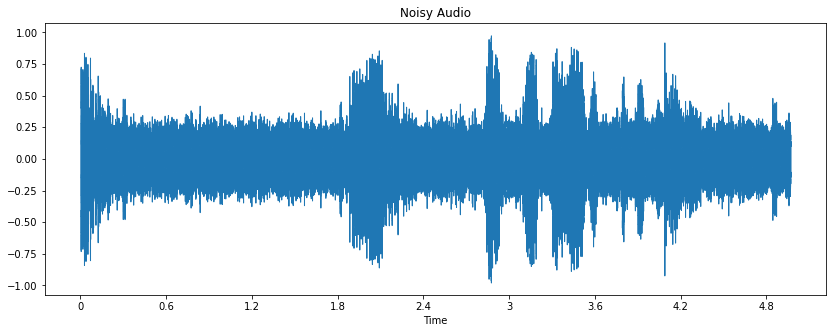

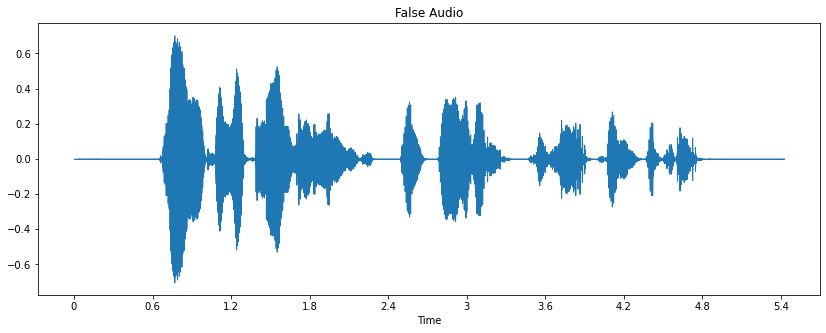

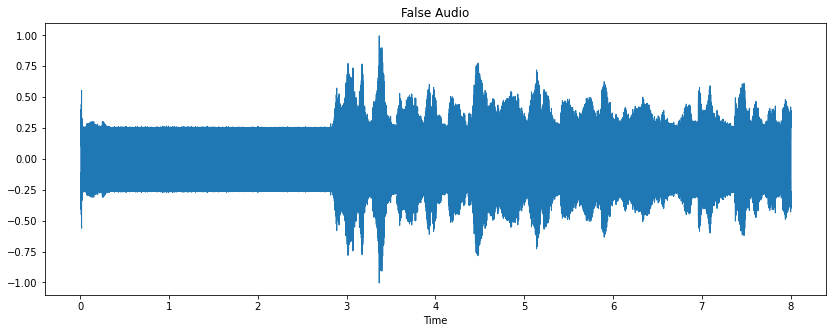

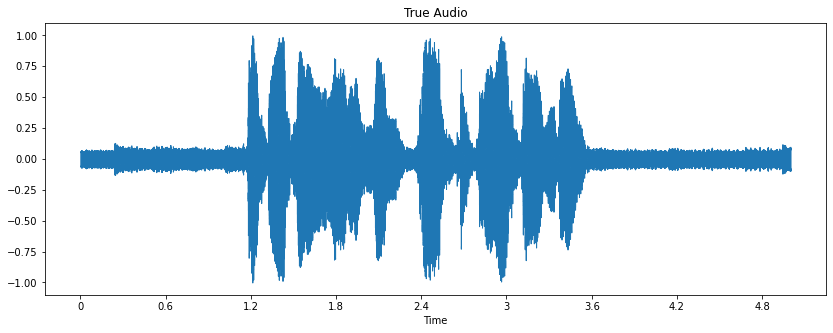

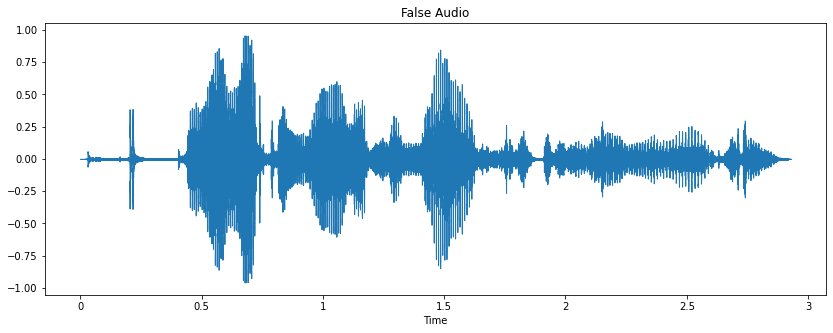

In [ ]:
#Plot waveforms of five different audio samples
# View the audio files
n = 5
for i in range(n):

 
    x , sr = librosa.load(trainset.iloc[i][2] + trainset.iloc[i][0])
 
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
        
    plt.title(name)

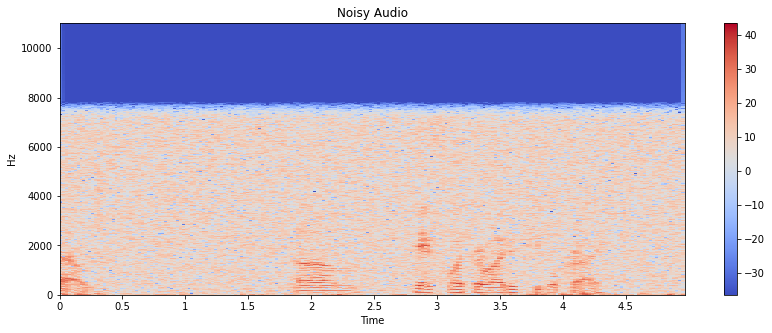

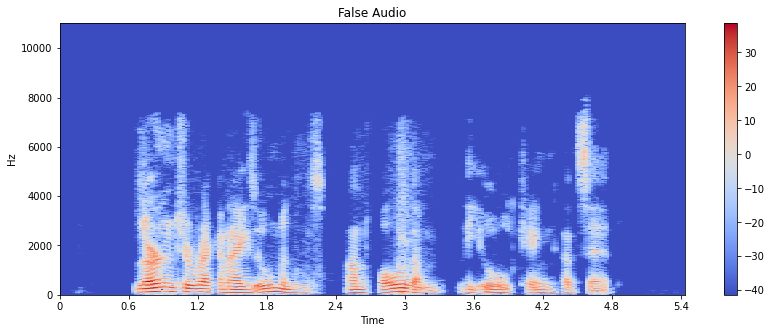

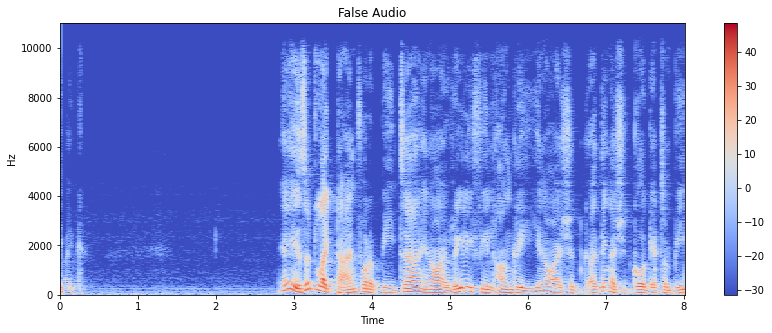

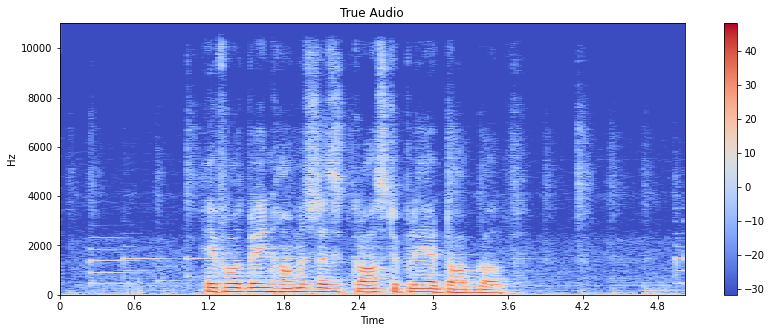

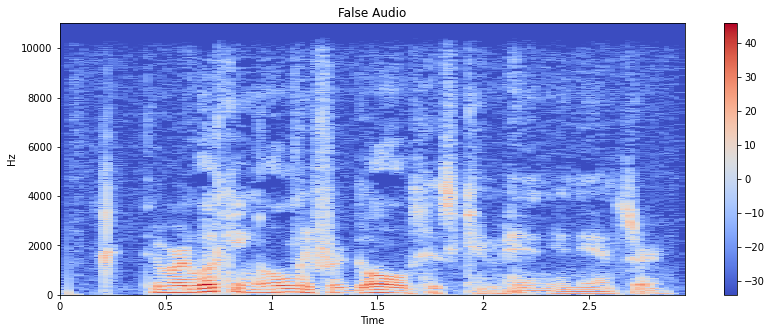

In [ ]:
#Spectogram of some random audio samples
#A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. 
#In 2-dimensional arrays, the first axis is frequency while the second axis is time.
n = 5
for i in range(n):

    x , sr = librosa.load(trainset.iloc[i][2] + trainset.iloc[i][0])
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
    plt.title(name)
    plt.colorbar()

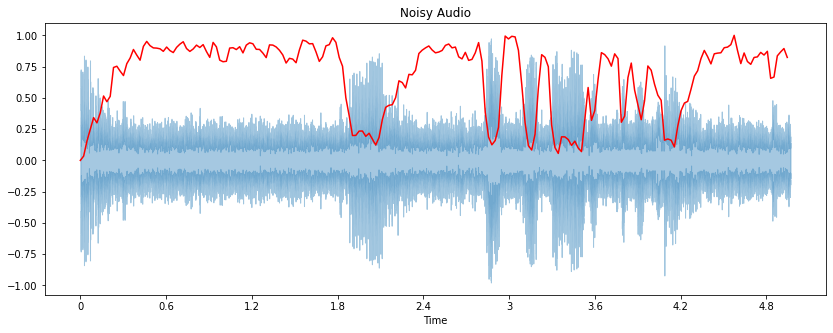

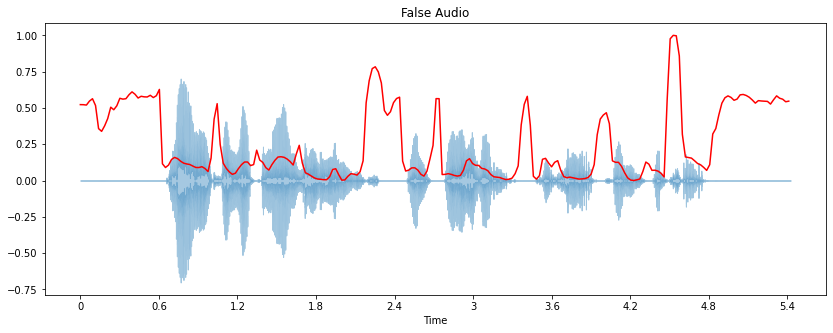

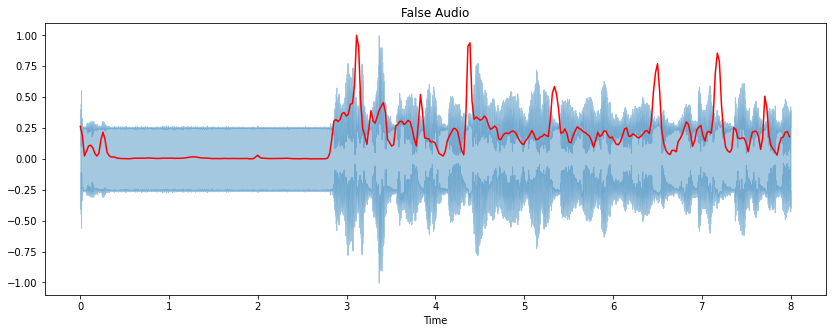

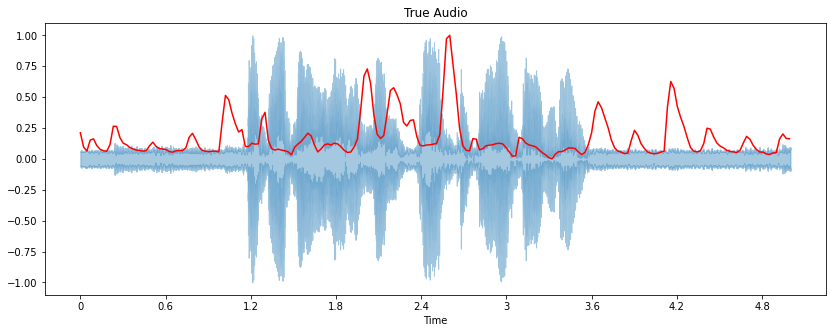

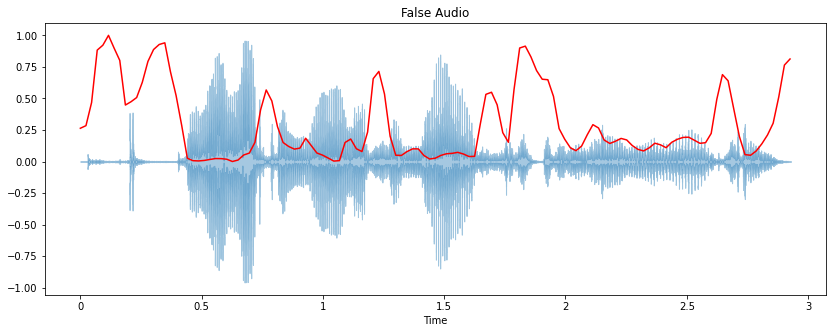

In [10]:
#Spectral Centroid indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. 
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

n = 5
for i in range(n):

    
    x , sr = librosa.load(trainset.iloc[i][2] + trainset.iloc[i][0])
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    # Normalising the spectral centroid for visualisation
    plt.figure(figsize=(14, 5))
    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
    plt.title(name)

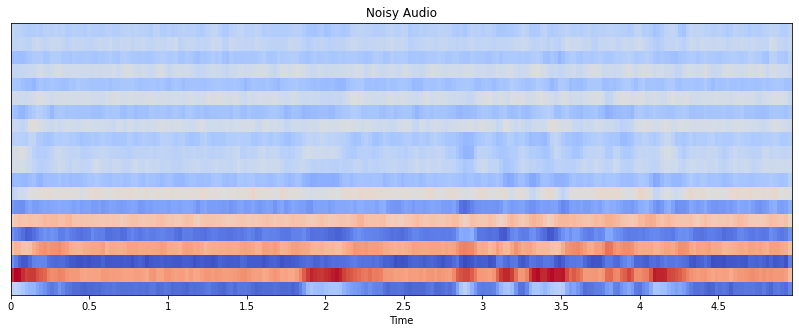

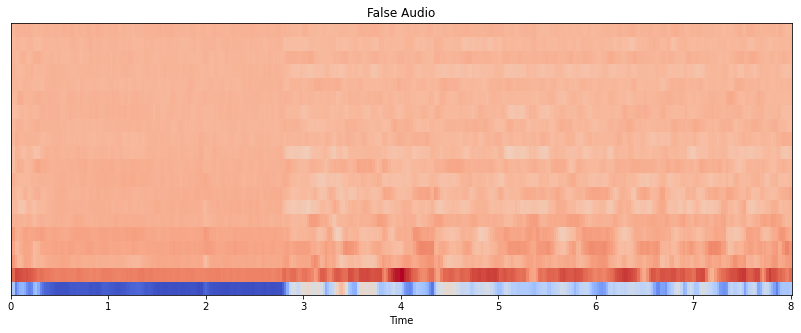

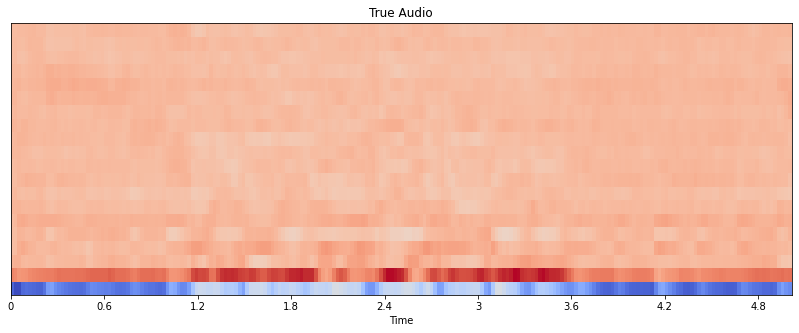

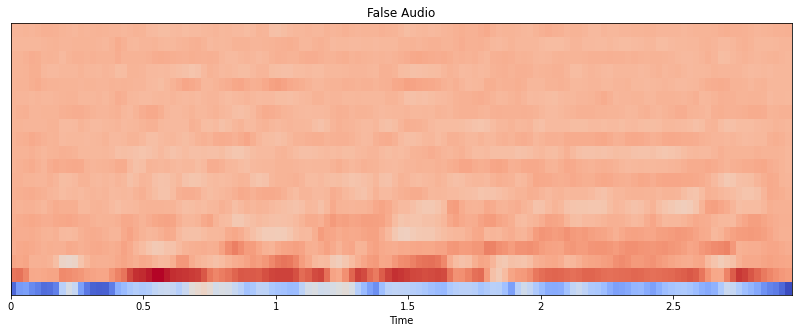

In [15]:
#Mel-Frequency Cepstral Coefficients
#The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features which concisely describe the overall shape of a spectral envelope.
#It models the characteristics of the human voice.


n = 5
for i in range(n):

    
    x , sr = librosa.load(trainset.iloc[i][2] + trainset.iloc[i][0])
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    mfccs = librosa.feature.mfcc(x, sr=sr)
  
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    n = trainset.iloc[i][0]
    if 'false' in n:
        name = 'False Audio'
    elif 'noise' in n:
        name = 'Noisy Audio'
    else:
        name = 'True Audio'
    plt.title(name)


In [ ]:
#in terms of challenges: 1) we have to determine if the input data is good enough to make the classification well 2) Extract the relevant features (feature enginering)
# 3) Select the appropriate model: CNN or RNN or just a ANN 4) Finally deploying the model with minimal latency for the end user will be the key.